# Final Project - NGC 3324 (Carina Nebula)

This notebook is the Instructor's attempt at the Final Project. The first part is the adaptation of the SEP tutorial (<a href='https://sep.readthedocs.io/en/stable/tutorial.html'>https://sep.readthedocs.io/en/stable/tutorial.html</a>) to the JWST image of NGC 3324 with NIRCam using filters clear+f090w.

NB: as per the instructions, I am using astropy instead of fitsio.

In [1]:
import numpy as np
import sep

In [2]:
# additional setup for reading the test image and displaying plots
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [3]:
# read image into standard 2-d numpy array

# file path and name
fits_image_filename = '/Users/aaguichine/Documents/UCSC/teaching/ASTR 19 - S25/final-project/2025_final/MAST_2025-04-17T0048/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits'
# open the hdul
hdul = fits.open(fits_image_filename)
# display information of the hdul
hdul.info()
# store the data into a standard 2D numpy array
data = hdul[1].data

Filename: /Users/aaguichine/Documents/UCSC/teaching/ASTR 19 - S25/final-project/2025_final/MAST_2025-04-17T0048/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     365   ()      
  1  SCI           1 ImageHDU        75   (14339, 8582)   float32   
  2  ERR           1 ImageHDU        10   (14339, 8582)   float32   
  3  CON           1 ImageHDU        10   (14339, 8582, 6)   int32   
  4  WHT           1 ImageHDU         9   (14339, 8582)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (14339, 8582)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (14339, 8582)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (14339, 8582)   float32   
  8  HDRTAB        1 BinTableHDU    532   160R x 261C   [23A, 5A, 3A, 45A, 6A, 13A, 7A, 5A, 6A, 7A, 10A, 4A, L, D, D, 32A, 50A, 32A, 21A, 3A, 3A, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A

If we don't run the line below, the data won't have the right data type and we will get an error saying:<br>
<code>ValueError: Input array with dtype `>f4` has non-native byte order. Only native byte order arrays are supported. To change the byte order of the array `data`, do `data = data.astype(data.dtype.newbyteorder('='))`</code><br>
so we do what the error message says to fix this issue.

In [43]:
data = data.astype(data.dtype.newbyteorder('='))

In [30]:
# remember that "when in doubt, print out"
# shape of data array
print("data shape: ",data.shape)
# min, mean, max
print("data min, mean, max: ",np.nanmin(data),np.nanmean(data),np.nanmax(data))
# number of nans
print("data number of NaNs: ",np.count_nonzero(np.isnan(data)))

data shape:  (8582, 14339)
data min, mean, max:  -3.2904701 1.6756457 5704.062
data number of NaNs:  4461608


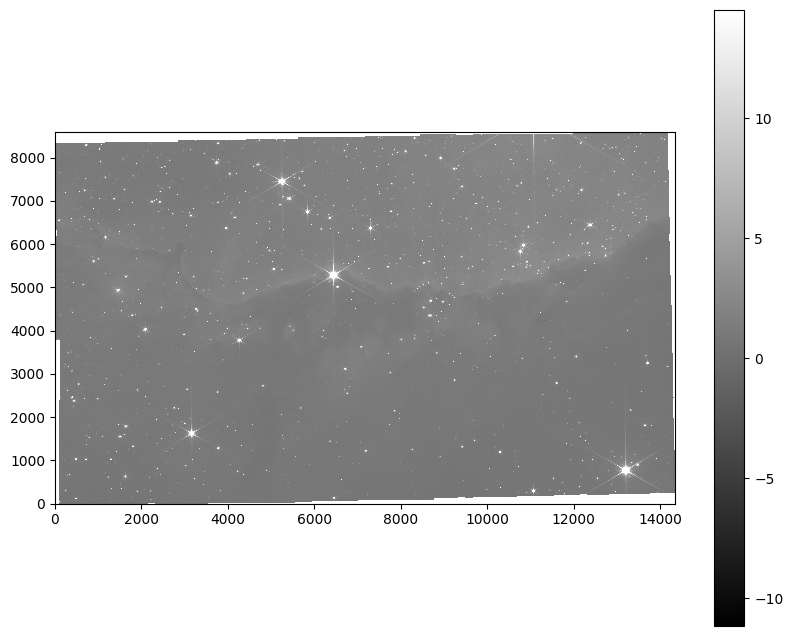

In [7]:
# show the image
m, s = np.nanmean(data), np.nanstd(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

The JWST image is different from the image in the tutorial. It is much bigger, but it also has a gas cloud. If we apply the default filter, some bright regions of the cloud of gas will be interpreter as sources, even though we want to filter them out.

To separate the background from sources, SEP takes small boxes of data and looks for outliers. In order to keep stars but remove the gas cloud, I am going to define a larger box. This will make sure that each box has bright source for reference. Then, I am increasing the threshold for what is considered to be a source, and what is the background.

In [8]:
# measure a spatially varying background on the image
bkg = sep.Background(data,fthresh=2.0,bw=512, bh=512)

In [9]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

1.1740961074829102
0.09724660217761993


In [10]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

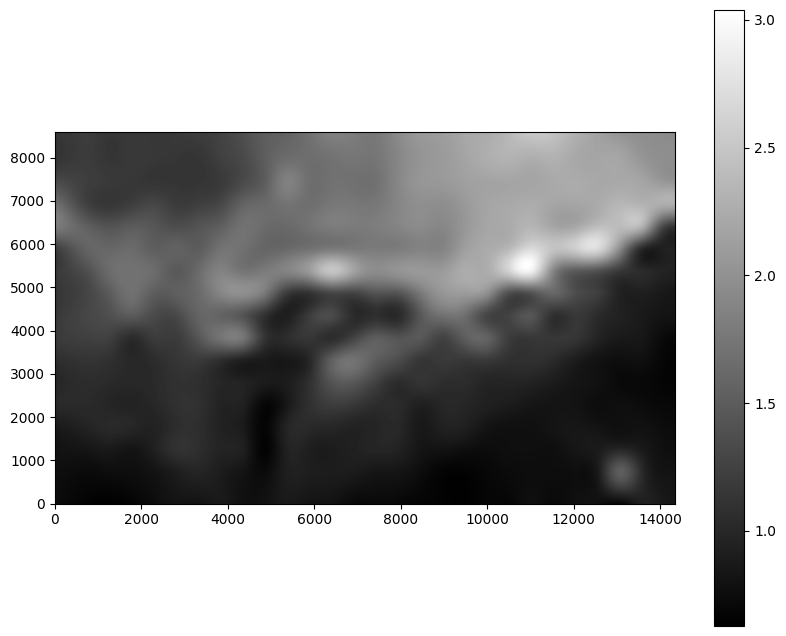

In [11]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

It took me a few attempt, but I'm pretty happy with the result because the background does look like it captures the shape of the gas cloud.

In [12]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

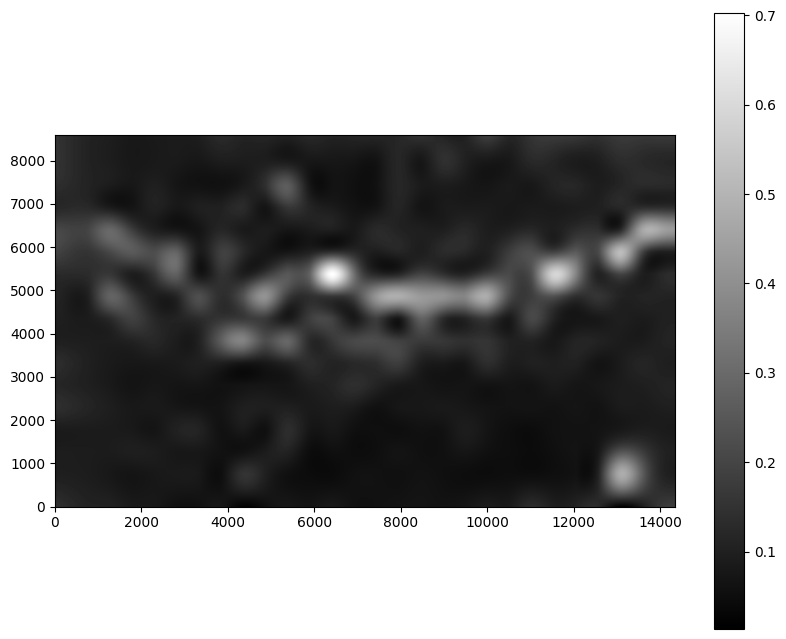

In [13]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

The background noise shows the places where there is a lot of variability (high stdev) = places where it can be potentially tricky to distinguish background from sources. As you can see, there is a lot of variability near the edge of the gas cloud, but also near bright sources.

In [14]:
# subtract the background
data_sub = data - bkg

If we use default values, SEP is going to identify A LOT of sources. But a lot of them are just noise. In a typical image I don't expect to see millions of sources. One way of solving this problem is by raising the detection threshold.

In [15]:
objects = sep.extract(data_sub, 25.0, err=bkg.globalrms)

In [16]:
# how many objects were detected
len(objects)

7394

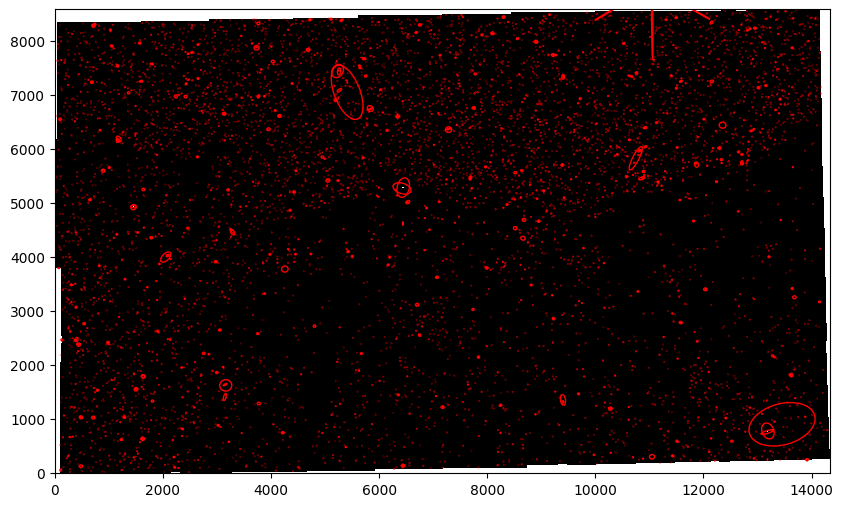

In [17]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

Note how there are more objects detected in the gas cloud. This is not a problem with our methodology. Gas clouds act as nurseries for young stars, so it is expected to see more sources where a gas cloud is located. It is not a bug, it's a feature!

In [18]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [19]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [20]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 249.162020 +/- 15.793324
object 1: flux = 472.739393 +/- 21.748703
object 2: flux = 35.167683 +/- 5.952677
object 3: flux = 57.106250 +/- 7.574517
object 4: flux = 81.081674 +/- 9.019270
object 5: flux = 168.293453 +/- 12.983071
object 6: flux = 512.429724 +/- 22.642767
object 7: flux = 92.698648 +/- 9.642010
object 8: flux = 39.131088 +/- 6.277006
object 9: flux = 753.588059 +/- 27.456436


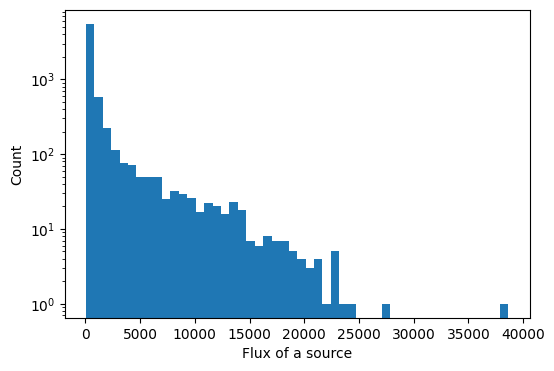

In [22]:
plt.figure(figsize=(6,4))
plt.hist(flux,bins=50,log=True)
plt.xlabel('Flux of a source')
plt.ylabel('Count')
plt.show()

In [32]:
print("Number of sources detected: ",len(flux))

Number of sources detected:  7394


In [33]:
print("Number of sources with nans: ",np.count_nonzero(np.isnan(flux)))

Number of sources with nans:  358


Let's find the location of the brightest source. We cannot look at the brightest pixel, but we can look for the biggest flux.

In [31]:
# use nanargmax instead of argmax because the array has nans.
i_max = np.nanargmax(flux)
print("Index of brightest source: ",i_max)
print("Value of flux: ",flux[i_max])
print("XY coordinates: ",objects['x'][i_max], objects['y'][i_max])

Index of brightest source:  6570
Value of flux:  38664.0788671875
XY coordinates:  5256.964878767826 7450.506735332351


In [34]:
print("mean, medial and stdev of flux: ",np.nanmean(flux),np.nanmedian(flux),np.nanstd(flux))

mean, medial and stdev of flux:  1054.9679621589323 170.1896208739281 2698.338646484841


In [35]:
print(f"The brightest source is {(flux[i_max]-np.nanmean(flux))/np.nanstd(flux):.1f} sigma away from the mean.")

The brightest source is 13.9 sigma away from the mean.


#### Reprojection

Why reproject the files? They have different sizes and orientations, if we don't reproject them we will have a problem.

In [ ]:
fname1 = '/Users/aaguichine/Documents/UCSC/teaching/ASTR 19 - S25/final-project/2025_final/MAST_2025-04-17T0048/JWST/jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d.fits'
fname2 = '/Users/aaguichine/Documents/UCSC/teaching/ASTR 19 - S25/final-project/2025_final/MAST_2025-04-17T0048/JWST/jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d.fits'
fname3 = '/Users/aaguichine/Documents/UCSC/teaching/ASTR 19 - S25/final-project/2025_final/MAST_2025-04-17T0048/JWST/jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d.fits'
fname4 = '/Users/aaguichine/Documents/UCSC/teaching/ASTR 19 - S25/final-project/2025_final/MAST_2025-04-17T0048/JWST/jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d.fits'
fname5 = '/Users/aaguichine/Documents/UCSC/teaching/ASTR 19 - S25/final-project/2025_final/MAST_2025-04-17T0048/JWST/jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits'

other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

In [48]:
# open the hdul
hdul1 = fits.open(fname1)
# store the data into a standard 2D numpy array
data1 = hdul1[1].data

data1 = data1.astype(data1.dtype.newbyteorder('='))
print("Shape of initial data: ", np.shape(data))
print("Shape of new data:     ", np.shape(data1))

Shape of initial data:  (8582, 14339)
Shape of new data:      (8582, 14340)


I already reprojected the files, so I'm making the cell in "raw" mode to avoid executing it when I run all cells.

In [49]:
# read image into standard 2-d numpy array
with fits.open(fits_image_filename) as hdul:
    # Print information about the HDU (Header Data Unit)
    hdul_info = hdul.info()
    # Access the header of the primary HDU (index 0)
    #header = hdul[0].header
    # Access the data of the primary HDU
    data1_090 = hdul[1].data
    #data = data.byteswap().newbyteorder()

new_filenames = [
    fname1.replace('.fits', '_reproj.fits'),
    fname2.replace('.fits', '_reproj.fits'),
    fname3.replace('.fits', '_reproj.fits'),
    fname4.replace('.fits', '_reproj.fits'),
    fname5.replace('.fits', '_reproj.fits'),
]

# read image into standard 2-d numpy array
with fits.open(new_filenames[0]) as hdul:
    # Print information about the HDU (Header Data Unit)
    hdul_info = hdul.info()
    # Access the header of the primary HDU (index 0)
    #header = hdul[0].header
    # Access the data of the primary HDU
    data1_187 = hdul[0].data
    #data = data.byteswap().newbyteorder()

# read image into standard 2-d numpy array
with fits.open(new_filenames[1]) as hdul:
    # Print information about the HDU (Header Data Unit)
    hdul_info = hdul.info()
    # Access the header of the primary HDU (index 0)
    #header = hdul[0].header
    # Access the data of the primary HDU
    data1_200 = hdul[0].data
    #data = data.byteswap().newbyteorder()

# read image into standard 2-d numpy array
with fits.open(new_filenames[2]) as hdul:
    # Print information about the HDU (Header Data Unit)
    hdul_info = hdul.info()
    # Access the header of the primary HDU (index 0)
    #header = hdul[0].header
    # Access the data of the primary HDU
    data1_335 = hdul[0].data
    #data = data.byteswap().newbyteorder()

# read image into standard 2-d numpy array
with fits.open(new_filenames[3]) as hdul:
    # Print information about the HDU (Header Data Unit)
    hdul_info = hdul.info()
    # Access the header of the primary HDU (index 0)
    #header = hdul[0].header
    # Access the data of the primary HDU
    data1_444 = hdul[0].data
    #data = data.byteswap().newbyteorder()

# read image into standard 2-d numpy array
with fits.open(new_filenames[4]) as hdul:
    # Print information about the HDU (Header Data Unit)
    hdul_info = hdul.info()
    # Access the header of the primary HDU (index 0)
    #header = hdul[0].header
    # Access the data of the primary HDU
    data1_470 = hdul[0].data
    #data = data.byteswap().newbyteorder()

Filename: /Users/aaguichine/Documents/UCSC/teaching/ASTR 19 - S25/final-project/2025_final/MAST_2025-04-17T0048/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     365   ()      
  1  SCI           1 ImageHDU        75   (14339, 8582)   float32   
  2  ERR           1 ImageHDU        10   (14339, 8582)   float32   
  3  CON           1 ImageHDU        10   (14339, 8582, 6)   int32   
  4  WHT           1 ImageHDU         9   (14339, 8582)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (14339, 8582)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (14339, 8582)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (14339, 8582)   float32   
  8  HDRTAB        1 BinTableHDU    532   160R x 261C   [23A, 5A, 3A, 45A, 6A, 13A, 7A, 5A, 6A, 7A, 10A, 4A, L, D, D, 32A, 50A, 32A, 21A, 3A, 3A, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A

Now all data has the same shape.

In [50]:
print(data1_090.shape)
print(data1_187.shape)

(8582, 14339)
(8582, 14339)


At this point, we loaded the data, and what follows is just manipulation of the numbers to render the RGB image in a way that I like.

In [51]:
#all data except the 470 are clear+filter, so first of all I attempt
#to extract the "clear" image by stacking the 5 first filters
#and taking the median
stacked_images = np.stack([data1_090, data1_187, data1_200, data1_335, data1_444], axis=0)
clear_image = np.median(stacked_images, axis=0)

In [52]:
#then I attempt to get the "pure" wavelengths by taking the original image - the clear data
#the last array is "444+470", so first I get the pure 444, and then I substract it
data1_all = np.zeros((len(data1_090[:,0]),len(data1_090[0,:]),6))
data1_all[:,:,0] = data1_090 - clear_image
data1_all[:,:,1] = data1_187 - clear_image
data1_all[:,:,2] = data1_200 - clear_image
data1_all[:,:,3] = data1_335 - clear_image
data1_all[:,:,4] = data1_444 - clear_image
data1_all[:,:,5] = data1_470 - (data1_444 - clear_image)

Hopefully, we have the "pure" wavelengths here.

In [53]:
# rescaling the image, essentially putting luminosities in log scale for nice viewing
def rescale_image(data):
    # copy the data to avoid accidentally overwritng it
    pdata_tmp = data.copy()

    # compute the mean anywhere exect for places what don't have a number (thats why there np.nanmean)
    n = np.nanmean(pdata_tmp)

    # if lower than vpmin, apply vpmin
    # if higher than vpmax, apply vpmax
    vpmin = 0.5*n
    vpmax = 10*n
    pdata_tmp[pdata_tmp < vpmin] = vpmin
    pdata_tmp[pdata_tmp > vpmax] = vpmax
    #pdata_tmp = np.nan_to_num(pdata_tmp,nan=vpmin)

    # scale by log10
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp

#remap from 0 to 1, for RGB purposes
def remap(data):
    pdata_tmp = data.copy()
    dmin = np.nanmin(pdata_tmp)
    dmax = np.nanmax(pdata_tmp)
    return (pdata_tmp - dmin) / (dmax - dmin)

In [54]:
data1_all_rescale = rescale_image(data1_all)

In [55]:
#making the rgb data here
rgb_image = np.zeros((len(data1_090[:,0]),len(data1_090[0,:]),3))

#filling the RGB channels according to the reference found online
#090 -> blue
#187 -> cyan
#200 -> green
#335 -> orange
#444 -> red
#470 -> yellow
rgb_image[:,:,0] = remap(data1_all_rescale[:,:,4] + 0.666*data1_all_rescale[:,:,3] + 0.5*data1_all_rescale[:,:,5])
rgb_image[:,:,1] = remap(data1_all_rescale[:,:,2] + data1_all_rescale[:,:,1] + 0.333*data1_all_rescale[:,:,3] + 0.5*data1_all_rescale[:,:,5])
rgb_image[:,:,2] = remap(data1_all_rescale[:,:,0] + data1_all_rescale[:,:,1])

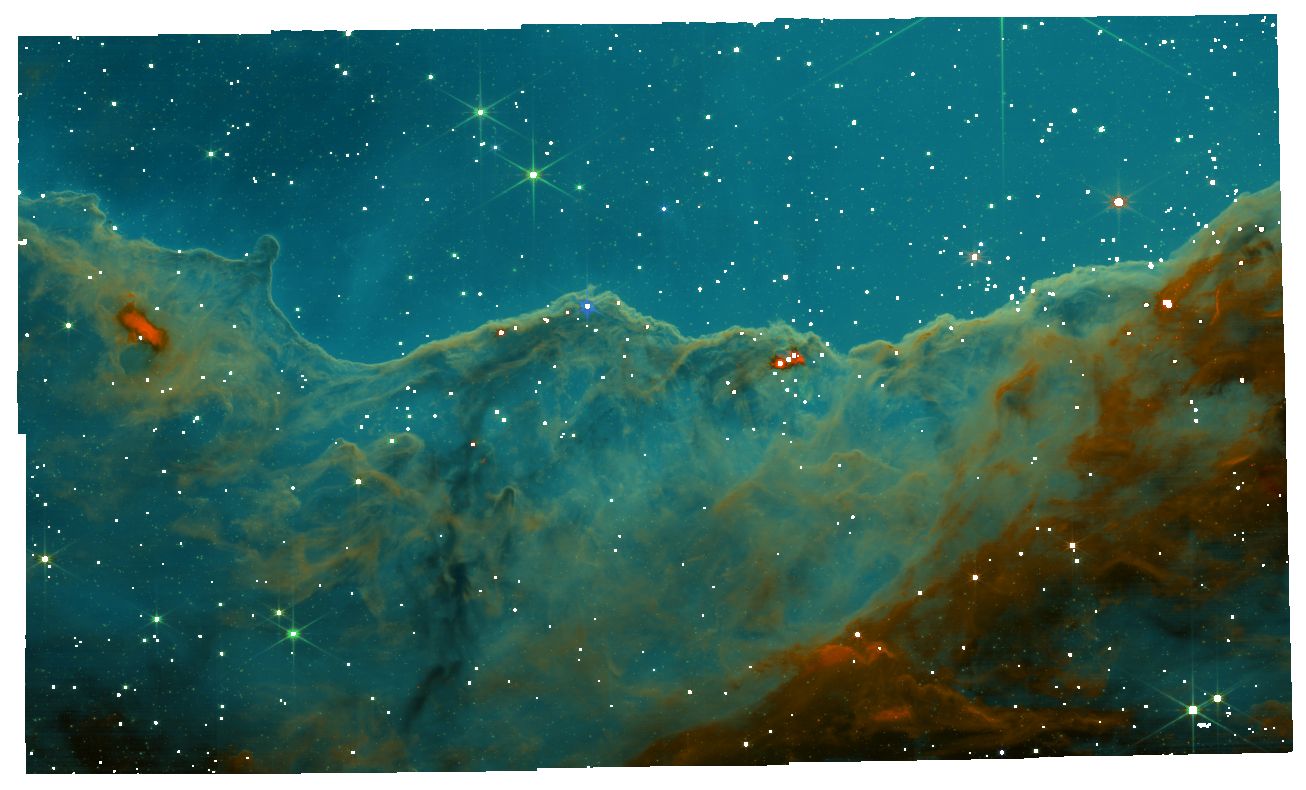

In [57]:
#plotting
f,ax = plt.subplots(1,1,figsize=(20,10))
ax.axis('off')
ax.imshow(rgb_image,origin='lower')
plt.savefig("my_carina.png",bbox_inches="tight",dpi=600)
plt.show()